# Analyzing the Mercari children's book dataset

## Import libraries and files

In [2]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split




In [3]:
os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,title
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,07/10/17,$3,C Sells,$4.00 | from Texas,Buy now,Book
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,07/15/17,$3,Investinyou,$4.00 | 3+ days | from Texas,Buy now,Book- When Bad Things Happen
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,05/26/19,$11,HWalters55,Free | from Washington,Buy now,Usborne Wipe-Clean- NEW
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,11/11/17,$3,Bargain hauls,$4.00 | 3+ days | from Minnesota,Buy now,Jingle Bells Book
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,08/19/16,$4,Dustyattic,Free | from Connecticut,Buy now,My Sister The Vampire


In [4]:
# Row count
rows = books.shape[0]
print("Number of rows: ", str(rows))

# Column count
columns = books.shape[1]
print("Number of columns: ", str(columns))

# Column names
print("Column names: ", str(books.columns))

# Indexing method
print("Index method: ", str(books.index))

# Data types of all columns
print("Data types for entire dataframe: ")
books.info()

# Data type of particular column
print("Data type of price column specifically is: ", str(books.price.dtype))



Number of rows:  49481
Number of columns:  11
Column names:  Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title'],
      dtype='object')
Index method:  RangeIndex(start=0, stop=49481, step=1)
Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49481 entries, 0 to 49480
Data columns (total 11 columns):
brand          25163 non-null object
category       49478 non-null object
condition      49481 non-null object
description    49481 non-null object
id             49481 non-null int64
posted         49481 non-null object
price          49481 non-null object
seller_name    49481 non-null object
shipping       49481 non-null object
sold           49481 non-null object
title          49481 non-null object
dtypes: int64(1), object(10)
memory usage: 4.2+ MB
Data type of price column specifically is:  object


## Clean-up time!

In [5]:
# eliminate duplicate rows
books = books.drop_duplicates()
books.shape[0]

22134

In [6]:
# id: convert to string
books.id = books.id.astype(str)
print("Data type of id column specifically is: ", str(books.id.dtype))

Data type of id column specifically is:  object


In [7]:
# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)
books['posted'].head()

0   2017-07-10
1   2017-07-15
2   2019-05-26
3   2017-11-11
4   2016-08-19
Name: posted, dtype: datetime64[ns]

In [8]:
# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')
books.sold.unique()

array(['available', 'SOLD'], dtype=object)

In [9]:
# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)
books.price

0         3
1         3
2        11
3         3
4         4
5         9
6         3
7         3
8         6
9        16
10       16
11       16
12       14
13       14
14       16
15       10
16       14
17       19
18        5
19        5
20        5
21        5
22       15
23        5
24       17
25       20
26       20
27       17
28       14
29       17
         ..
49349     5
49350     5
49351     5
49352     5
49353     5
49354     5
49355     5
49356     5
49357     5
49358    12
49359    11
49360    10
49361    12
49362    10
49363    10
49364    16
49365    15
49366    15
49367    15
49368    14
49369    18
49370    10
49374     5
49380    41
49382    48
49387    30
49399     5
49421    30
49476    53
49477    23
Name: price, Length: 22134, dtype: int64

## Feature Creation

In [10]:
# create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost

books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')
books.shipping_cost

0         4.00
1         4.00
2         0.00
3         4.00
4         0.00
5         0.00
6         4.00
7         4.00
8         0.00
9         5.25
10        0.00
11        0.00
12        0.00
13        0.00
14        0.00
15        7.00
16        0.00
17        0.00
18        4.00
19        6.50
20        4.25
21        0.00
22        0.00
23        5.25
24        6.00
25        5.25
26        0.00
27        4.25
28       11.00
29        3.80
         ...  
49349     4.00
49350     5.25
49351     5.25
49352     6.50
49353     4.25
49354     4.25
49355     4.25
49356     4.25
49357     4.25
49358     0.00
49359     4.25
49360     0.00
49361     0.00
49362     5.25
49363     4.00
49364     0.00
49365     0.00
49366     4.25
49367     0.00
49368     0.00
49369     0.00
49370     0.00
49374     5.25
49380     0.00
49382     0.00
49387     9.00
49399     4.25
49421     9.00
49476     0.00
49477     0.00
Name: shipping_cost, Length: 22134, dtype: float64

In [11]:
# create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time

books['shipping_time'] = books['shipping'].apply(shipping_time)
books.shipping_time

0        None
1           3
2        None
3           3
4        None
5        None
6           3
7           2
8           3
9           3
10       None
11       None
12       None
13          3
14       None
15          2
16          3
17       None
18       None
19          3
20          3
21       None
22       None
23          2
24       None
25          3
26          2
27          2
28          2
29          8
         ... 
49349       3
49350       3
49351       3
49352       3
49353       3
49354       3
49355       3
49356       3
49357       3
49358    None
49359       3
49360    None
49361       2
49362       2
49363       3
49364       3
49365       3
49366       3
49367       3
49368    None
49369    None
49370    None
49374       3
49380    None
49382    None
49387    None
49399       3
49421    None
49476       3
49477    None
Name: shipping_time, Length: 22134, dtype: object

In [12]:
# create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location

books['shipping_location'] = books['shipping'].apply(shipping_location)
books.shipping_location

0                 Texas
1                 Texas
2            Washington
3             Minnesota
4           Connecticut
5              Illinois
6             Minnesota
7                Nevada
8              Michigan
9              Illinois
10           California
11                Texas
12       South Carolina
13         Pennsylvania
14             Arkansas
15                Texas
16       North Carolina
17             Illinois
18             New York
19                Texas
20        West Virginia
21           California
22       North Carolina
23               Oregon
24        Massachusetts
25             Colorado
26              Florida
27           California
28              Arizona
29             New York
              ...      
49349             Texas
49350          Illinois
49351          Maryland
49352           Indiana
49353          Arkansas
49354           Florida
49355        Washington
49356              Ohio
49357           Florida
49358          Illinois
49359       Miss

In [13]:
# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']
books.total_price

0         7.00
1         7.00
2        11.00
3         7.00
4         4.00
5         9.00
6         7.00
7         7.00
8         6.00
9        21.25
10       16.00
11       16.00
12       14.00
13       14.00
14       16.00
15       17.00
16       14.00
17       19.00
18        9.00
19       11.50
20        9.25
21        5.00
22       15.00
23       10.25
24       23.00
25       25.25
26       20.00
27       21.25
28       25.00
29       20.80
         ...  
49349     9.00
49350    10.25
49351    10.25
49352    11.50
49353     9.25
49354     9.25
49355     9.25
49356     9.25
49357     9.25
49358    12.00
49359    15.25
49360    10.00
49361    12.00
49362    15.25
49363    14.00
49364    16.00
49365    15.00
49366    19.25
49367    15.00
49368    14.00
49369    18.00
49370    10.00
49374    10.25
49380    41.00
49382    48.00
49387    39.00
49399     9.25
49421    39.00
49476    53.00
49477    23.00
Name: total_price, Length: 22134, dtype: float64

In [14]:
# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping

books['free_shipping'] = books.shipping_cost.apply(free_shipping)
books.free_shipping

0        0
1        0
2        1
3        0
4        1
5        1
6        0
7        0
8        1
9        0
10       1
11       1
12       1
13       1
14       1
15       0
16       1
17       1
18       0
19       0
20       0
21       1
22       1
23       0
24       0
25       0
26       1
27       0
28       0
29       0
        ..
49349    0
49350    0
49351    0
49352    0
49353    0
49354    0
49355    0
49356    0
49357    0
49358    1
49359    0
49360    1
49361    1
49362    0
49363    0
49364    1
49365    1
49366    0
49367    1
49368    1
49369    1
49370    1
49374    0
49380    1
49382    1
49387    0
49399    0
49421    0
49476    1
49477    1
Name: free_shipping, Length: 22134, dtype: int64

In [15]:
# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()

zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)
books.brand_included

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       1
17       0
18       0
19       0
20       0
21       0
22       1
23       1
24       0
25       0
26       1
27       0
28       1
29       0
        ..
49349    0
49350    1
49351    0
49352    0
49353    1
49354    0
49355    1
49356    1
49357    0
49358    1
49359    0
49360    0
49361    0
49362    1
49363    0
49364    1
49365    0
49366    0
49367    1
49368    0
49369    0
49370    0
49374    1
49380    0
49382    1
49387    0
49399    1
49421    0
49476    0
49477    0
Name: brand_included, Length: 22134, dtype: int64

In [16]:
# New column sold_true
def sold_true(status):
    if status == 'SOLD':
        sold_true = 1
    else:
        sold_true = 0
    return sold_true

books['sold_true'] = books.sold.apply(sold_true)

In [17]:
# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length

books['description_length'] = books.description.apply(description_length)
books.description_length

0         31
1        106
2        250
3         47
4         64
5         42
6         46
7        154
8        250
9        122
10        53
11       117
12       193
13        65
14        48
15        42
16       250
17       101
18       250
19       250
20        41
21        32
22        46
23       110
24        29
25       181
26       250
27       141
28        49
29       182
        ... 
49349     53
49350    109
49351    185
49352     37
49353     51
49354    111
49355    250
49356     87
49357    195
49358    113
49359     39
49360    250
49361     79
49362    110
49363    250
49364    137
49365    183
49366    241
49367     93
49368    219
49369    250
49370    202
49374     82
49380    250
49382    250
49387    250
49399     78
49421    250
49476    250
49477    250
Name: description_length, Length: 22134, dtype: int64

In [18]:
# New column condition_ordinal from new = 1, like new = 2, good = 3, fair = 4, poor = 5
def condition_ordinal(condition):
    if condition == "New":
        condition_ordinal = 1
    elif condition == "Like new":
        condition_ordinal = 2
    elif condition == "Good":
        condition_ordinal = 3
    elif condition == "Fair":
        condition_ordinal = 4
    elif condition == "Poor":
        condition_ordinal = 5
    else: condition_ordinal = None
    return condition_ordinal

books['condition_ordinal'] = books.condition.apply(condition_ordinal)
books.condition_ordinal

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
49349    5
49350    5
49351    5
49352    5
49353    5
49354    5
49355    5
49356    5
49357    5
49358    5
49359    5
49360    5
49361    5
49362    5
49363    5
49364    5
49365    5
49366    5
49367    5
49368    5
49369    5
49370    5
49374    5
49380    5
49382    5
49387    5
49399    5
49421    5
49476    5
49477    5
Name: condition_ordinal, Length: 22134, dtype: int64

In [19]:
# New column days_since_posted. Was scraped on 2019-06-10 so range from 0 and up.
from datetime import date

def days_since_posted(posted):
    posted_day = date(posted.year, posted.month, posted.day)
    scrape_day = date(2019, 6, 10)
    days_since_posted = scrape_day - posted_day
    return days_since_posted.days

books['days_since_posted'] = books.posted.apply(days_since_posted)
books.days_since_posted

0         700
1         695
2          15
3         576
4        1025
5          46
6         576
7         562
8         226
9         682
10        517
11        397
12        434
13         74
14        566
15        528
16         41
17         85
18        575
19        215
20        481
21         97
22          7
23         94
24        572
25         31
26         37
27        203
28         10
29        446
         ... 
49349     561
49350      30
49351      85
49352     335
49353      85
49354     136
49355      50
49356     116
49357     183
49358     176
49359     225
49360      40
49361     203
49362      88
49363     811
49364      64
49365      79
49366     224
49367      78
49368      17
49369      17
49370      33
49374      30
49380      11
49382     276
49387    1008
49399     116
49421    1159
49476     166
49477     235
Name: days_since_posted, Length: 22134, dtype: int64

In [20]:
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,...,shipping_cost,shipping_time,shipping_location,total_price,free_shipping,brand_included,sold_true,description_length,condition_ordinal,days_since_posted
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,2017-07-10,3,C Sells,$4.00 | from Texas,available,...,4.0,None,Texas,7.0,0,0,0,31,1,700
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,2017-07-15,3,Investinyou,$4.00 | 3+ days | from Texas,available,...,4.0,3,Texas,7.0,0,0,0,106,1,695
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,2019-05-26,11,HWalters55,Free | from Washington,available,...,0.0,None,Washington,11.0,1,0,0,250,1,15
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,2017-11-11,3,Bargain hauls,$4.00 | 3+ days | from Minnesota,available,...,4.0,3,Minnesota,7.0,0,0,0,47,1,576
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,2016-08-19,4,Dustyattic,Free | from Connecticut,available,...,0.0,None,Connecticut,4.0,1,0,0,64,1,1025


## Now time for some exploratory statistics!

/Users/mleong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


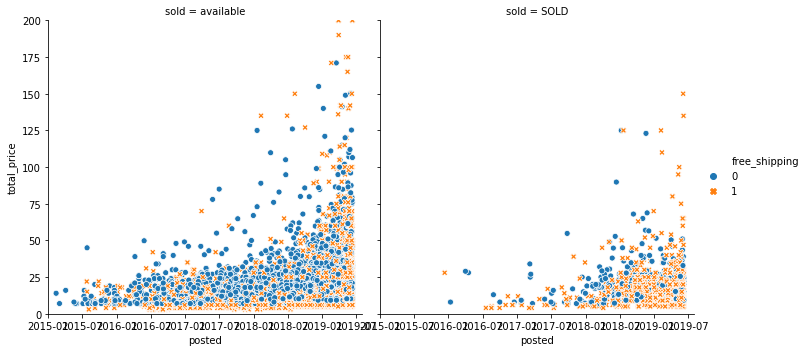

In [21]:
#Total price against date color coded by sold or for sale
# There seem to be a higher proporiton of free shipping purchases to non free shipping purchases in the sold graph!
%matplotlib inline
import seaborn as sns
book_plot = sns.relplot(x="posted", y="total_price", col="sold", hue = "free_shipping", style="free_shipping", data=books)
book_plot.set(xlim=(datetime.date(2015, 1, 1), datetime.date(2019, 8, 1)), ylim=(0,200))
book_plot


In [22]:

prop = 989/(21142+989)
print("The proportion of items that sell from total listings:", str(prop), "\nAbout 4.5%")

The proportion of items that sell from total listings: 0.044688446071121955 
About 4.5%


In [23]:
# Can make a new column based on seller data (# of other sales, proportion of sales to posts for seller).
# This doesn't really make sense to include in our model though because it's not something a first time poster 
# can really do anything about.
b = books.groupby('seller_name').count().sort_values(['id'], ascending = False)
b.id

seller_name
Sunshine Rehs Books     244
Gemini's Bookshelf      216
Pmcgriff9998            189
twoarrowsbookclub       177
1uniqueevent            165
VACATION  6/8-6/17      161
Kcasey46                137
TRACY'S TREASURES       132
TaraMae1981             114
elizabeth6              110
Educationalmall’s       102
WheretheSidewalkEnds     97
Kelly Harvey             92
Becca's Bookshelf        87
Rotamart                 85
lavendersand666          82
jojocloset_a             73
Dominica Taylor          71
This and That shop       67
tinytab                  64
jessicamoris3            64
ParkersClothingMore      61
Samantha Leach           58
Theo's Bookshelf         55
LokisBooksNMore          55
Baylebroyles             47
Adela                    45
MeekoPrints              45
hstewart21158            45
Dreamy_Lily              44
                       ... 
Maja Maja S’              1
Maison                    1
Mainstreet Mojo           1
Magic Beauty              1
Magen   

## Now time to try and create a logistic regression!!

In [24]:
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,...,shipping_cost,shipping_time,shipping_location,total_price,free_shipping,brand_included,sold_true,description_length,condition_ordinal,days_since_posted
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,2017-07-10,3,C Sells,$4.00 | from Texas,available,...,4.0,None,Texas,7.0,0,0,0,31,1,700
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,2017-07-15,3,Investinyou,$4.00 | 3+ days | from Texas,available,...,4.0,3,Texas,7.0,0,0,0,106,1,695
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,2019-05-26,11,HWalters55,Free | from Washington,available,...,0.0,None,Washington,11.0,1,0,0,250,1,15
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,2017-11-11,3,Bargain hauls,$4.00 | 3+ days | from Minnesota,available,...,4.0,3,Minnesota,7.0,0,0,0,47,1,576
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,2016-08-19,4,Dustyattic,Free | from Connecticut,available,...,0.0,None,Connecticut,4.0,1,0,0,64,1,1025


In [45]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_names_books = ['condition_ordinal', 'days_since_posted', 'price', 'shipping_cost', 'total_price', 'free_shipping', 
                       'brand_included', 'description_length'
                      ]
X_books = books[feature_names_books]
y_books = books['sold_true']

X_train, X_test, y_train, y_test = train_test_split(X_books, y_books, random_state=0)


# Need to look at features and think about whether things needs to be scaled. Shipping location excluded 
# because one hot encoding that does not seem to be worthwhile. I am going to create a condition_ordinal feature scale.
# Also going to create a days_since_posted scale.

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Dummy Classifier

In [47]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)
print(dummy_majority.score(X_test_scaled, y_test))

dummy_majority_predicted = dummy_majority.predict(X_test_scaled)
confusion = confusion_matrix(y_test, dummy_majority_predicted)

print('Random class-majoirty prediction (dummy classifier)\n', confusion)

0.9557282255149981
Random class-majoirty prediction (dummy classifier)
 [[5289    0]
 [ 245    0]]


### KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test_scaled, y_test)))

knn_predicted = knn.predict(X_test_scaled)
knn_confusion = confusion_matrix(y_test, knn_predicted)

print('KNN\n', knn_confusion)

Accuracy of K-NN classifier on training set: 0.9562
Accuracy of K-NN classifier on test set: 0.9545
KNN
 [[5280    9]
 [ 243    2]]


### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs').fit(X_train_scaled, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test_scaled, y_test)))

logreg_predicted = logreg.predict(X_test_scaled)
logreg_confusion = confusion_matrix(y_test, logreg_predicted)

print('Logistic Regression\n', logreg_confusion)

Accuracy of Logistic regression classifier on training set: 0.9552
Accuracy of Logistic regression classifier on test set: 0.9555
Logistic Regression
 [[5288    1]
 [ 245    0]]


### Ridge Regression with Feature Normalization

In [57]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))



ridge regression linear model intercept: 0.0038691210702343146
ridge regression linear model coeff:
[0.00842241 0.0449298  0.11057702 0.0080746  0.11117518 0.02438453
 0.00911248 0.01702354]
R-squared score (training): 0.007
R-squared score (test): 0.008
Number of non-zero features: 8


### SVC

In [58]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'
     .format(svc.score(X_train_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.4f}'
     .format(svc.score(X_test_scaled, y_test)))

svc_predicted = svc.predict(X_test_scaled)
svc_confusion = confusion_matrix(y_test, svc_predicted)

print('SVC \n', svc_confusion)

Accuracy of Linear SVC classifier on training set: 0.9552
Accuracy of Linear SVC classifier on test set: 0.9555
SVC 
 [[5288    1]
 [ 245    0]]


### Naive Bayes

In [61]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train_scaled, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'
     .format(nb.score(X_train_scaled, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'
     .format(nb.score(X_test_scaled, y_test)))

nb_predicted = nb.predict(X_test_scaled)
nb_confusion = confusion_matrix(y_test, nb_predicted)

print('Naive Bayes \n', nb_confusion)

Accuracy of GaussianNB classifier on training set: 0.9392
Accuracy of GaussianNB classifier on test set: 0.9405
Naive Bayes 
 [[5193   96]
 [ 233   12]]


### Random Forests

In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 10, random_state=0).fit(X_train_scaled, y_train)
print('Accuracy of RF classifier on training set: {:.4f}'
     .format(rf.score(X_train_scaled, y_train)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf.score(X_test_scaled, y_test)))

rf_predicted = rf.predict(X_test_scaled)
rf_confusion = confusion_matrix(y_test, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on training set: 0.9885
Accuracy of RF classifier on test set: 0.9507
Random Forest 
 [[5259   30]
 [ 243    2]]


### Gradient-Boosted Decision Trees

In [68]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gbdt.fit(X_train_scaled, y_train)
print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.4f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'
     .format(gbdt.score(X_test_scaled, y_test)))

gbdt_predicted = gbdt.predict(X_test_scaled)
gbdt_confusion = confusion_matrix(y_test, gbdt_predicted)

print('Gradient-Boosted Decision Trees \n', gbdt_confusion)

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.9552
Accuracy of GBDT classifier on test set: 0.9557
Gradient-Boosted Decision Trees 
 [[5289    0]
 [ 245    0]]


## Evaluating these metrics with alternative models

In [69]:
from sklearn.metrics import classification_report

print('Dummy predictor (most frequent) \n', classification_report(y_test, dummy_majority_predicted, target_names=['available', 'sold']))
print('KNN \n', classification_report(y_test, knn_predicted, target_names=['available', 'sold']))
print('Logistic regression\n', classification_report(y_test, logreg_predicted, target_names = ['available', 'sold']))
print('SVC\n', classification_report(y_test, svc_predicted, target_names = ['available', 'sold']))
print('Naive Bayes\n', classification_report(y_test, nb_predicted, target_names = ['available', 'sold']))
print('Random Forest\n', classification_report(y_test, rf_predicted, target_names = ['available', 'sold']))
print('Gradient-Boosted Decision Trees\n', classification_report(y_test, gbdt_predicted, target_names = ['available', 'sold']))

Dummy predictor (most frequent) 
               precision    recall  f1-score   support

   available       0.96      1.00      0.98      5289
        sold       0.00      0.00      0.00       245

   micro avg       0.96      0.96      0.96      5534
   macro avg       0.48      0.50      0.49      5534
weighted avg       0.91      0.96      0.93      5534

KNN 
               precision    recall  f1-score   support

   available       0.96      1.00      0.98      5289
        sold       0.18      0.01      0.02       245

   micro avg       0.95      0.95      0.95      5534
   macro avg       0.57      0.50      0.50      5534
weighted avg       0.92      0.95      0.93      5534

Logistic regression
               precision    recall  f1-score   support

   available       0.96      1.00      0.98      5289
        sold       0.00      0.00      0.00       245

   micro avg       0.96      0.96      0.96      5534
   macro avg       0.48      0.50      0.49      5534
weighted avg 

/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio